<a href="https://colab.research.google.com/github/sunxueliang96/WF-FrameWork/blob/master/GAN_WF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Mount Google Drive as folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [0]:
cd /content/drive/'My Drive'/datasets/no_paded/close_world/knn

/content/drive/My Drive/datasets/no_paded/close_world/knn


In [0]:
ls

X_knnbatch.pkl  y_knnbatch.pkl


In [0]:
import pickle
from collections import Counter
import numpy as np
with open ('X_knnbatch.pkl','rb') as handle:
    X_train = np.array(pickle.load(handle,encoding='iso-8859-1'))
with open ('y_knnbatch.pkl','rb') as handle:
    y_train = np.array(pickle.load(handle,encoding='iso-8859-1'))

maxlen = 2000
NB_classes = len(Counter(y_train).keys())

print('Number of samples :' , X_train.shape[0])
print('Type of samples :' , NB_classes)
print('Average sequence length: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('maxlen setted as {}'.format(maxlen))

Number of samples : 9100
Type of samples : 100
Average sequence length: 1816
maxlen setted as 2000


In [0]:
from keras.preprocessing import sequence
from keras.utils import np_utils


X_train = sequence.pad_sequences(X_train,maxlen=maxlen,padding='post',truncating='post')

# append the N+1 class as fake 
y_train = np.append(y_train , NB_classes)
NB_classes = NB_classes + 1
print('the id of faker is {}'.format(NB_classes))
y_train = np_utils.to_categorical(y_train, NB_classes)


Using TensorFlow backend.


the id of faker is 101


In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input, Lambda, Concatenate
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam


def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

NB_split = [None,100,50,25,10]       # that means 1%,2%,5%,10%
NB_generator_output = [None]

overhead = 100      #control the overhead rate here
print('the overhaed is {} %'.format(overhead))

overhead_split = overhead*maxlen//100//(len(NB_split)-1)

for split in NB_split[1:]:
    NB_output = overhead_split//split
    NB_generator_output.append(NB_output)

NB_generator_output



the overhaed is 100 %


[None, 5, 10, 20, 50]

In [112]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects


def custom_activation(x):
    return (K.sigmoid(x) * 2) - 1

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def create_generator():
    inputs_1  = Input(shape=(maxlen,))
    #block #1
    splits_1 = Lambda(lambda x: tf.split(x, num_or_size_splits=NB_split[1], axis=1))(inputs_1)       #tf.split int for number, vector for sizes
    branch_outputs_1 = []
    for i in range(NB_split[1]):
        x_1 = Dense(1024, activation='relu')(splits_1[i])   #single full connected layer for temporary
        outputs_noise_1 = Dense(NB_generator_output[1], activation=custom_activation)(x_1)
        outputs_noise_1 = Lambda(lambda x: tf.math.divide_no_nan(x,tf.abs(x)))(outputs_noise_1)
        outputs_concat_1 = keras.layers.concatenate([splits_1[i], outputs_noise_1])
        branch_outputs_1.append(outputs_concat_1)
    out_1 = Concatenate()(branch_outputs_1)

    #block #2
    splits_2 = Lambda(lambda x: tf.split(x, num_or_size_splits=NB_split[2], axis=1))(out_1)
    branch_outputs_2 = []
    for i in range(NB_split[2]):
        x_2 = Dense(1024, activation='relu')(splits_2[i])   #single full connected layer for temporary
        outputs_noise_2 = Dense(NB_generator_output[2], activation=custom_activation)(x_2)
        outputs_noise_2 = Lambda(lambda x: tf.math.divide_no_nan(x,tf.abs(x)))(outputs_noise_2)
        outputs_concat_2 = keras.layers.concatenate([splits_2[i], outputs_noise_2])
        branch_outputs_2.append(outputs_concat_2)
    out_2 = Concatenate()(branch_outputs_2)
    #block #3
    splits_3 = Lambda(lambda x: tf.split(x, num_or_size_splits=NB_split[3], axis=1))(out_2)
    branch_outputs_3 = []
    for i in range(NB_split[3]):
        x_3 = Dense(1024, activation='relu')(splits_3[i])   #single full connected layer for temporary
        outputs_noise_3 = Dense(NB_generator_output[3], activation=custom_activation)(x_3)
        outputs_noise_3 = Lambda(lambda x: tf.math.divide_no_nan(x,tf.abs(x)))(outputs_noise_3)
        outputs_concat_3 = keras.layers.concatenate([splits_3[i], outputs_noise_3])
        branch_outputs_3.append(outputs_concat_3)
    out_3 = Concatenate()(branch_outputs_3)

    #block #4
    splits_4 = Lambda(lambda x: tf.split(x, num_or_size_splits=NB_split[4], axis=1))(out_3)
    branch_outputs_4 = []
    for i in range(NB_split[4]):
        x_4 = Dense(1024, activation='relu')(splits_4[i])   #single full connected layer for temporary
        outputs_noise_4 = Dense(NB_generator_output[4], activation=custom_activation)(x_4)
        outputs_noise_4 = Lambda(lambda x: tf.math.divide_no_nan(x,tf.abs(x)))(outputs_noise_4)
        outputs_concat_4 = keras.layers.concatenate([splits_4[i], outputs_noise_4])
        branch_outputs_4.append(outputs_concat_4)
    out_4 = Concatenate()(branch_outputs_4)

    generator = Model(inputs=inputs_1, outputs=out_4)    
    generator.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return generator
    
g=create_generator()
NB_output  = g.layers[-1].output_shape[-1]
g.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
lambda_2056 (Lambda)            [(None, 20), (None,  0           input_28[0][0]                   
__________________________________________________________________________________________________
dense_4068 (Dense)              (None, 1024)         21504       lambda_2056[0][0]                
__________________________________________________________________________________________________
dense_4070 (Dense)              (None, 1024)         21504       lambda_2056[0][1]                
___________________________________________________________________________________________

In [113]:
def create_discriminator(input_dim=NB_output):
    discriminator=Sequential()
    inputs = Input(shape=(input_dim,))
    x = Dense(512, activation='relu')(inputs)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(units=NB_classes, activation='softmax')(x)
    discriminator = Model(inputs=inputs,outputs=outputs)
    discriminator.compile(loss='categorical_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 4000)              0         
_________________________________________________________________
dense_4438 (Dense)           (None, 512)               2048512   
_________________________________________________________________
dense_4439 (Dense)           (None, 1024)              525312    
_________________________________________________________________
dense_4440 (Dense)           (None, 512)               524800    
_________________________________________________________________
dense_4441 (Dense)           (None, 128)               65664     
_________________________________________________________________
dense_4442 (Dense)           (None, 101)               13029     
Total params: 3,177,317
Trainable params: 3,177,317
Non-trainable params: 0
________________________________________________

In [114]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(maxlen,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='categorical_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 2000)              0         
_________________________________________________________________
model_23 (Model)             (None, 4000)              13503440  
_________________________________________________________________
model_24 (Model)             (None, 101)               3177317   
Total params: 16,680,757
Trainable params: 13,503,440
Non-trainable params: 3,177,317
_________________________________________________________________


In [0]:
generator= create_generator()
discriminator= create_discriminator()
gan = create_gan(discriminator, generator)

In [116]:
from tqdm import tqdm
dis_loss = []
gan_loss = []

def training(NB_epochs=300, batch_size=128):
    batch_count = X_train.shape[0] / batch_size
    print('Number of batches {}'.format(batch_count))

    #valid = np.ones((batch_size, 1))  # real is 111111111111111111111111
    #fake = np.ones((batch_size, NB_classes))  # fake is 00000000000000000000000000
    fake = []

    for i in range(batch_size):
        fake.append(y_train[-1])
    fake = np.array(fake) 

    for epoch in tqdm(range(NB_epochs)):
        #  Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)        # Select a random batch of sequences
        seqs = X_train[idx]
        y = y_train[idx]

        discriminator.trainable=True
        gen_seqs = generator.predict(seqs)    #  Generate a batch of new seqs
        seqs = sequence.pad_sequences(seqs,maxlen=NB_output,padding='post',truncating='post')
        d_loss_real = discriminator.train_on_batch(seqs,y)
        d_loss_fake = discriminator.train_on_batch(gen_seqs,fake)
        d_loss = 0.5*np.add(d_loss_real,d_loss_fake)
        dis_loss.append(d_loss_real)

        #  Train Generator
        seqs = sequence.pad_sequences(seqs,maxlen=maxlen,padding='post',truncating='post')
        discriminator.trainable=False
        g_loss = gan.train_on_batch(seqs,fake)
        gan_loss.append(g_loss)
        if epoch in range(0,NB_epochs,NB_epochs//10):
            print ('dis:{}gan{}'.format(d_loss_real,g_loss))
        #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
training(NB_epochs=300, batch_size=128)




  0%|          | 0/300 [00:00<?, ?it/s]

Number of batches 71.09375




  0%|          | 1/300 [02:34<12:49:36, 154.43s/it]

dis:4.6454362869262695gan3.788275718688965




  1%|          | 2/300 [02:34<8:57:42, 108.26s/it] 

  1%|          | 3/300 [02:35<6:15:50, 75.93s/it] 

  1%|▏         | 4/300 [02:35<4:22:55, 53.29s/it]

  2%|▏         | 5/300 [02:36<3:04:06, 37.44s/it]

  2%|▏         | 6/300 [02:36<2:09:06, 26.35s/it]

  2%|▏         | 7/300 [02:37<1:30:43, 18.58s/it]

  3%|▎         | 8/300 [02:37<1:03:55, 13.14s/it]

  3%|▎         | 9/300 [02:38<45:15,  9.33s/it]  

  3%|▎         | 10/300 [02:38<32:12,  6.66s/it]

  4%|▎         | 11/300 [02:39<23:07,  4.80s/it]

  4%|▍         | 12/300 [02:39<16:45,  3.49s/it]

  4%|▍         | 13/300 [02:39<12:19,  2.58s/it]

  5%|▍         | 14/300 [02:40<09:15,  1.94s/it]

  5%|▌         | 15/300 [02:40<07:04,  1.49s/it]

  5%|▌         | 16/300 [02:41<05:36,  1.19s/it]

  6%|▌         | 17/300 [02:41<04:32,  1.04it/s]

  6%|▌         | 18/300 [02:42<03:47,  1.24it/s]

  6%|▋         | 19/300 [02:42<03:16,  1.43it/s]

  7%|▋         | 20/300 [02:43<02:53,  1.61it/s]

  7%|▋         | 21/300 [02:43<02:41,

dis:3.7899701595306396gan0.0002836748317349702




 11%|█         | 32/300 [02:48<02:01,  2.21it/s]

 11%|█         | 33/300 [02:48<02:01,  2.20it/s]

 11%|█▏        | 34/300 [02:49<01:59,  2.22it/s]

 12%|█▏        | 35/300 [02:49<01:58,  2.23it/s]

 12%|█▏        | 36/300 [02:50<01:58,  2.22it/s]

 12%|█▏        | 37/300 [02:50<01:58,  2.22it/s]

 13%|█▎        | 38/300 [02:51<01:58,  2.22it/s]

 13%|█▎        | 39/300 [02:51<01:58,  2.21it/s]

 13%|█▎        | 40/300 [02:52<01:56,  2.23it/s]

 14%|█▎        | 41/300 [02:52<01:56,  2.22it/s]

 14%|█▍        | 42/300 [02:52<01:54,  2.25it/s]

 14%|█▍        | 43/300 [02:53<01:54,  2.24it/s]

 15%|█▍        | 44/300 [02:53<01:54,  2.24it/s]

 15%|█▌        | 45/300 [02:54<01:52,  2.26it/s]

 15%|█▌        | 46/300 [02:54<01:54,  2.21it/s]

 16%|█▌        | 47/300 [02:55<01:53,  2.22it/s]

 16%|█▌        | 48/300 [02:55<01:54,  2.21it/s]

 16%|█▋        | 49/300 [02:56<01:52,  2.23it/s]

 17%|█▋        | 50/300 [02:56<01:51,  2.25it/s]

 17%|█▋        | 51/300 [02:57<01:52,  2.21it/s]

dis:2.5031659603118896gan0.00010806087811943144




 21%|██        | 62/300 [03:01<01:45,  2.25it/s]

 21%|██        | 63/300 [03:02<01:45,  2.25it/s]

 21%|██▏       | 64/300 [03:02<01:44,  2.25it/s]

 22%|██▏       | 65/300 [03:03<01:45,  2.24it/s]

 22%|██▏       | 66/300 [03:03<01:44,  2.24it/s]

 22%|██▏       | 67/300 [03:04<01:42,  2.26it/s]

 23%|██▎       | 68/300 [03:04<01:43,  2.25it/s]

 23%|██▎       | 69/300 [03:05<01:43,  2.22it/s]

 23%|██▎       | 70/300 [03:05<01:43,  2.23it/s]

 24%|██▎       | 71/300 [03:05<01:42,  2.23it/s]

 24%|██▍       | 72/300 [03:06<01:41,  2.25it/s]

 24%|██▍       | 73/300 [03:06<01:41,  2.23it/s]

 25%|██▍       | 74/300 [03:07<01:40,  2.24it/s]

 25%|██▌       | 75/300 [03:07<01:39,  2.25it/s]

 25%|██▌       | 76/300 [03:08<01:39,  2.26it/s]

 26%|██▌       | 77/300 [03:08<01:37,  2.28it/s]

 26%|██▌       | 78/300 [03:09<01:38,  2.24it/s]

 26%|██▋       | 79/300 [03:09<01:37,  2.26it/s]

 27%|██▋       | 80/300 [03:09<01:37,  2.25it/s]

 27%|██▋       | 81/300 [03:10<01:36,  2.26it/s]

dis:1.6958740949630737gan0.00021612437558360398




 31%|███       | 92/300 [03:15<01:33,  2.22it/s]

 31%|███       | 93/300 [03:15<01:33,  2.22it/s]

 31%|███▏      | 94/300 [03:16<01:32,  2.23it/s]

 32%|███▏      | 95/300 [03:16<01:32,  2.22it/s]

 32%|███▏      | 96/300 [03:17<01:31,  2.22it/s]

 32%|███▏      | 97/300 [03:17<01:31,  2.21it/s]

 33%|███▎      | 98/300 [03:17<01:30,  2.22it/s]

 33%|███▎      | 99/300 [03:18<01:30,  2.22it/s]

 33%|███▎      | 100/300 [03:18<01:30,  2.21it/s]

 34%|███▎      | 101/300 [03:19<01:29,  2.23it/s]

 34%|███▍      | 102/300 [03:19<01:28,  2.23it/s]

 34%|███▍      | 103/300 [03:20<01:27,  2.24it/s]

 35%|███▍      | 104/300 [03:20<01:27,  2.24it/s]

 35%|███▌      | 105/300 [03:21<01:27,  2.23it/s]

 35%|███▌      | 106/300 [03:21<01:27,  2.22it/s]

 36%|███▌      | 107/300 [03:21<01:26,  2.24it/s]

 36%|███▌      | 108/300 [03:22<01:25,  2.24it/s]

 36%|███▋      | 109/300 [03:22<01:24,  2.25it/s]

 37%|███▋      | 110/300 [03:23<01:24,  2.26it/s]

 37%|███▋      | 111/300 [03:23<01:23

dis:2.128737449645996gan0.0004044059896841645




 41%|████      | 122/300 [03:28<01:19,  2.23it/s]

 41%|████      | 123/300 [03:29<01:18,  2.25it/s]

 41%|████▏     | 124/300 [03:29<01:19,  2.22it/s]

 42%|████▏     | 125/300 [03:30<01:18,  2.23it/s]

 42%|████▏     | 126/300 [03:30<01:17,  2.25it/s]

 42%|████▏     | 127/300 [03:30<01:17,  2.23it/s]

 43%|████▎     | 128/300 [03:31<01:16,  2.25it/s]

 43%|████▎     | 129/300 [03:31<01:16,  2.24it/s]

 43%|████▎     | 130/300 [03:32<01:15,  2.24it/s]

 44%|████▎     | 131/300 [03:32<01:15,  2.23it/s]

 44%|████▍     | 132/300 [03:33<01:16,  2.21it/s]

 44%|████▍     | 133/300 [03:33<01:14,  2.23it/s]

 45%|████▍     | 134/300 [03:34<01:14,  2.23it/s]

 45%|████▌     | 135/300 [03:34<01:14,  2.23it/s]

 45%|████▌     | 136/300 [03:34<01:13,  2.23it/s]

 46%|████▌     | 137/300 [03:35<01:13,  2.22it/s]

 46%|████▌     | 138/300 [03:35<01:12,  2.22it/s]

 46%|████▋     | 139/300 [03:36<01:11,  2.25it/s]

 47%|████▋     | 140/300 [03:36<01:11,  2.25it/s]

 47%|████▋     | 141/300 [03:

dis:0.9868757128715515gan4.963930769008584e-05




 51%|█████     | 152/300 [03:42<01:07,  2.19it/s]

 51%|█████     | 153/300 [03:42<01:06,  2.22it/s]

 51%|█████▏    | 154/300 [03:43<01:06,  2.19it/s]

 52%|█████▏    | 155/300 [03:43<01:05,  2.21it/s]

 52%|█████▏    | 156/300 [03:43<01:05,  2.20it/s]

 52%|█████▏    | 157/300 [03:44<01:04,  2.22it/s]

 53%|█████▎    | 158/300 [03:44<01:03,  2.23it/s]

 53%|█████▎    | 159/300 [03:45<01:04,  2.20it/s]

 53%|█████▎    | 160/300 [03:45<01:03,  2.22it/s]

 54%|█████▎    | 161/300 [03:46<01:03,  2.20it/s]

 54%|█████▍    | 162/300 [03:46<01:02,  2.19it/s]

 54%|█████▍    | 163/300 [03:47<01:02,  2.19it/s]

 55%|█████▍    | 164/300 [03:47<01:02,  2.19it/s]

 55%|█████▌    | 165/300 [03:48<01:01,  2.19it/s]

 55%|█████▌    | 166/300 [03:48<01:00,  2.21it/s]

 56%|█████▌    | 167/300 [03:48<01:00,  2.20it/s]

 56%|█████▌    | 168/300 [03:49<00:59,  2.22it/s]

 56%|█████▋    | 169/300 [03:49<00:59,  2.22it/s]

 57%|█████▋    | 170/300 [03:50<00:58,  2.24it/s]

 57%|█████▋    | 171/300 [03:

dis:1.1578845977783203gan2.8795884645660408e-05




 61%|██████    | 182/300 [03:55<00:52,  2.23it/s]

 61%|██████    | 183/300 [03:56<00:52,  2.23it/s]

 61%|██████▏   | 184/300 [03:56<00:51,  2.24it/s]

 62%|██████▏   | 185/300 [03:56<00:50,  2.26it/s]

 62%|██████▏   | 186/300 [03:57<00:51,  2.23it/s]

 62%|██████▏   | 187/300 [03:57<00:50,  2.24it/s]

 63%|██████▎   | 188/300 [03:58<00:50,  2.22it/s]

 63%|██████▎   | 189/300 [03:58<00:49,  2.22it/s]

 63%|██████▎   | 190/300 [03:59<00:49,  2.24it/s]

 64%|██████▎   | 191/300 [03:59<00:49,  2.22it/s]

 64%|██████▍   | 192/300 [04:00<00:48,  2.24it/s]

 64%|██████▍   | 193/300 [04:00<00:48,  2.23it/s]

 65%|██████▍   | 194/300 [04:01<00:47,  2.24it/s]

 65%|██████▌   | 195/300 [04:01<00:46,  2.24it/s]

 65%|██████▌   | 196/300 [04:01<00:46,  2.25it/s]

 66%|██████▌   | 197/300 [04:02<00:45,  2.27it/s]

 66%|██████▌   | 198/300 [04:02<00:45,  2.24it/s]

 66%|██████▋   | 199/300 [04:03<00:44,  2.25it/s]

 67%|██████▋   | 200/300 [04:03<00:44,  2.24it/s]

 67%|██████▋   | 201/300 [04:

dis:0.6064736843109131gan2.6907666324405e-05




 71%|███████   | 212/300 [04:09<00:39,  2.23it/s]

 71%|███████   | 213/300 [04:09<00:38,  2.24it/s]

 71%|███████▏  | 214/300 [04:09<00:38,  2.25it/s]

 72%|███████▏  | 215/300 [04:10<00:38,  2.20it/s]

 72%|███████▏  | 216/300 [04:10<00:38,  2.21it/s]

 72%|███████▏  | 217/300 [04:11<00:37,  2.23it/s]

 73%|███████▎  | 218/300 [04:11<00:37,  2.21it/s]

 73%|███████▎  | 219/300 [04:12<00:36,  2.23it/s]

 73%|███████▎  | 220/300 [04:12<00:36,  2.21it/s]

 74%|███████▎  | 221/300 [04:13<00:35,  2.23it/s]

 74%|███████▍  | 222/300 [04:13<00:35,  2.23it/s]

 74%|███████▍  | 223/300 [04:14<00:34,  2.22it/s]

 75%|███████▍  | 224/300 [04:14<00:33,  2.24it/s]

 75%|███████▌  | 225/300 [04:14<00:33,  2.24it/s]

 75%|███████▌  | 226/300 [04:15<00:32,  2.25it/s]

 76%|███████▌  | 227/300 [04:15<00:32,  2.22it/s]

 76%|███████▌  | 228/300 [04:16<00:32,  2.23it/s]

 76%|███████▋  | 229/300 [04:16<00:31,  2.23it/s]

 77%|███████▋  | 230/300 [04:17<00:31,  2.21it/s]

 77%|███████▋  | 231/300 [04:

dis:0.7790273427963257gan2.165752994187642e-05




 81%|████████  | 242/300 [04:22<00:26,  2.21it/s]

 81%|████████  | 243/300 [04:23<00:25,  2.20it/s]

 81%|████████▏ | 244/300 [04:23<00:25,  2.23it/s]

 82%|████████▏ | 245/300 [04:23<00:24,  2.22it/s]

 82%|████████▏ | 246/300 [04:24<00:24,  2.24it/s]

 82%|████████▏ | 247/300 [04:24<00:23,  2.23it/s]

 83%|████████▎ | 248/300 [04:25<00:23,  2.24it/s]

 83%|████████▎ | 249/300 [04:25<00:22,  2.24it/s]

 83%|████████▎ | 250/300 [04:26<00:22,  2.22it/s]

 84%|████████▎ | 251/300 [04:26<00:21,  2.24it/s]

 84%|████████▍ | 252/300 [04:27<00:21,  2.25it/s]

 84%|████████▍ | 253/300 [04:27<00:20,  2.28it/s]

 85%|████████▍ | 254/300 [04:27<00:20,  2.26it/s]

 85%|████████▌ | 255/300 [04:28<00:19,  2.25it/s]

 85%|████████▌ | 256/300 [04:28<00:19,  2.26it/s]

 86%|████████▌ | 257/300 [04:29<00:19,  2.22it/s]

 86%|████████▌ | 258/300 [04:29<00:18,  2.24it/s]

 86%|████████▋ | 259/300 [04:30<00:18,  2.25it/s]

 87%|████████▋ | 260/300 [04:30<00:17,  2.25it/s]

 87%|████████▋ | 261/300 [04:

dis:0.5971033573150635gan5.694182982551865e-05




 91%|█████████ | 272/300 [04:35<00:12,  2.23it/s]

 91%|█████████ | 273/300 [04:36<00:12,  2.23it/s]

 91%|█████████▏| 274/300 [04:36<00:11,  2.21it/s]

 92%|█████████▏| 275/300 [04:37<00:11,  2.23it/s]

 92%|█████████▏| 276/300 [04:37<00:10,  2.24it/s]

 92%|█████████▏| 277/300 [04:38<00:10,  2.22it/s]

 93%|█████████▎| 278/300 [04:38<00:09,  2.23it/s]

 93%|█████████▎| 279/300 [04:39<00:09,  2.23it/s]

 93%|█████████▎| 280/300 [04:39<00:08,  2.22it/s]

 94%|█████████▎| 281/300 [04:40<00:08,  2.24it/s]

 94%|█████████▍| 282/300 [04:40<00:08,  2.23it/s]

 94%|█████████▍| 283/300 [04:40<00:07,  2.24it/s]

 95%|█████████▍| 284/300 [04:41<00:07,  2.23it/s]

 95%|█████████▌| 285/300 [04:41<00:06,  2.24it/s]

 95%|█████████▌| 286/300 [04:42<00:06,  2.20it/s]

 96%|█████████▌| 287/300 [04:42<00:05,  2.21it/s]

 96%|█████████▌| 288/300 [04:43<00:05,  2.22it/s]

 96%|█████████▋| 289/300 [04:43<00:04,  2.22it/s]

 97%|█████████▋| 290/300 [04:44<00:04,  2.22it/s]

 97%|█████████▋| 291/300 [04:

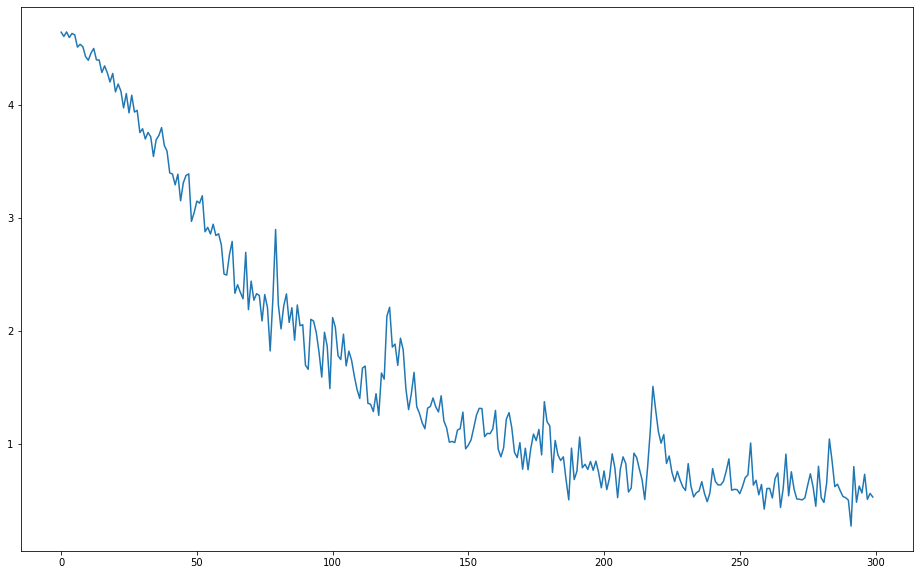

In [117]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(dis_loss)


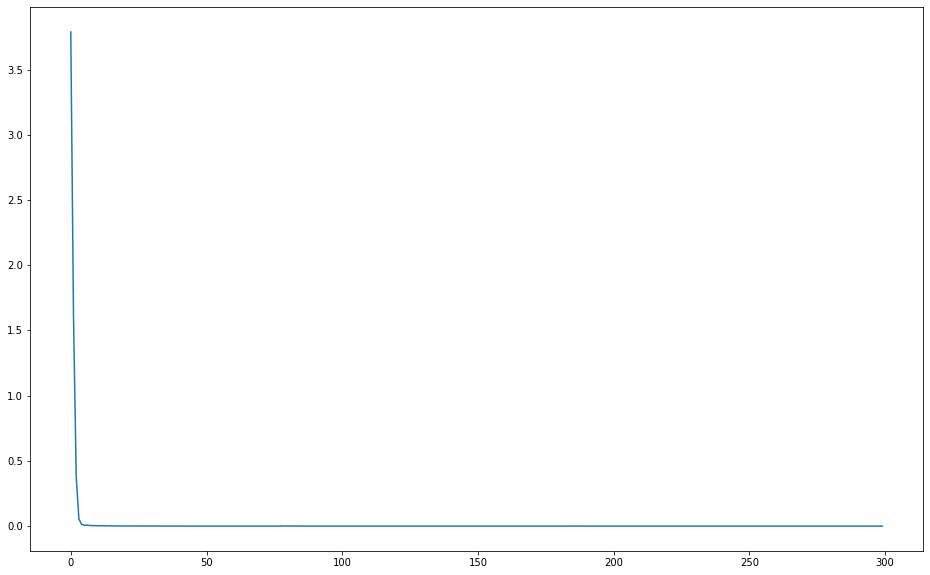

In [118]:
plt.figure(figsize=(16,10))
plt.plot(gan_loss)

In [0]:
#CNN
from keras import Input,Model,Sequential
from keras.layers import Embedding,GlobalAveragePooling1D,Dense,Dropout
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform
from keras.optimizers import Adamax
def CNN(input_shape, classes):
    model = Sequential()
    #Block1
    filter_num = ['None',32,64,128,256]
    kernel_size = ['None',8,8,8,8]
    conv_stride_size = ['None',1,1,1,1]
    pool_stride_size = ['None',4,4,4,4]
    pool_size = ['None',8,8,8,8]

    model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1], input_shape=(input_shape,1),
                      strides=conv_stride_size[1], padding='same',
                      name='block1_conv1'))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU(alpha=1.0, name='block1_adv_act1'))
    model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1],
                      strides=conv_stride_size[1], padding='same',
                      name='block1_conv2'))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU(alpha=1.0, name='block1_adv_act2'))
    model.add(MaxPooling1D(pool_size=pool_size[1], strides=pool_stride_size[1],
                            padding='same', name='block1_pool'))
    model.add(Dropout(0.1, name='block1_dropout'))

    model.add(Conv1D(filters=filter_num[2], kernel_size=kernel_size[2],
                      strides=conv_stride_size[2], padding='same',
                      name='block2_conv1'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block2_act1'))

    model.add(Conv1D(filters=filter_num[2], kernel_size=kernel_size[2],
                      strides=conv_stride_size[2], padding='same',
                      name='block2_conv2'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block2_act2'))
    model.add(MaxPooling1D(pool_size=pool_size[2], strides=pool_stride_size[3],
                            padding='same', name='block2_pool'))
    model.add(Dropout(0.1, name='block2_dropout'))

    model.add(Conv1D(filters=filter_num[3], kernel_size=kernel_size[3],
                      strides=conv_stride_size[3], padding='same',
                      name='block3_conv1'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block3_act1'))
    model.add(Conv1D(filters=filter_num[3], kernel_size=kernel_size[3],
                      strides=conv_stride_size[3], padding='same',
                      name='block3_conv2'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block3_act2'))
    model.add(MaxPooling1D(pool_size=pool_size[3], strides=pool_stride_size[3],
                            padding='same', name='block3_pool'))
    model.add(Dropout(0.1, name='block3_dropout'))

    model.add(Conv1D(filters=filter_num[4], kernel_size=kernel_size[4],
                      strides=conv_stride_size[4], padding='same',
                      name='block4_conv1'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block4_act1'))
    model.add(Conv1D(filters=filter_num[4], kernel_size=kernel_size[4],
                      strides=conv_stride_size[4], padding='same',
                      name='block4_conv2'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block4_act2'))
    model.add(MaxPooling1D(pool_size=pool_size[4], strides=pool_stride_size[4],
                            padding='same', name='block4_pool'))
    model.add(Dropout(0.1, name='block4_dropout'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(512, kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='fc1_act'))

    model.add(Dropout(0.7, name='fc1_dropout'))

    model.add(Dense(512, kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='fc2_act'))

    model.add(Dropout(0.5, name='fc2_dropout'))

    model.add(Dense(classes, kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    model.add(Activation('softmax', name="softmax"))
    return model

In [0]:
import keras
from keras import backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
 
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

In [0]:
from sklearn.model_selection import train_test_split
with open ('X_knnbatch.pkl','rb') as handle:
    X_test = np.array(pickle.load(handle,encoding='iso-8859-1'))
with open ('y_knnbatch.pkl','rb') as handle:
    y_test = np.array(pickle.load(handle,encoding='iso-8859-1'))
X_train_saved,X_test_saved,y_train_saved,y_test_saved = train_test_split(X_test,y_test,test_size=0.3)

X_train_saved = sequence.pad_sequences(X_train_saved,maxlen=maxlen,padding='post',truncating='post')
X_test_saved = sequence.pad_sequences(X_test_saved,maxlen=maxlen,padding='post',truncating='post')
X_train_saved = X_train_saved[:,:,np.newaxis]
X_test_saved = X_test_saved[:,:,np.newaxis]
y_train_saved = np_utils.to_categorical(y_train_saved, NB_classes-1)
y_test_saved = np_utils.to_categorical(y_test_saved, NB_classes-1)

model_CNN_org = CNN(maxlen,NB_classes-1)
model_CNN_org.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','top_k_categorical_accuracy', precision, recall, fmeasure])

history_CNN_org = model_CNN_org.fit(X_train_saved,y_train_saved,batch_size=128,epochs=30,validation_data=(X_test_saved,y_test_saved),verbose=0)

In [0]:
from sklearn.model_selection import train_test_split
with open ('X_knnbatch.pkl','rb') as handle:
    X_test = np.array(pickle.load(handle,encoding='iso-8859-1'))
with open ('y_knnbatch.pkl','rb') as handle:
    y_test = np.array(pickle.load(handle,encoding='iso-8859-1'))

X_test = sequence.pad_sequences(X_test,maxlen=maxlen,padding='post',truncating='post')
X_test = generator.predict(X_test)
X_train_saved,X_test_saved,y_train_saved,y_test_saved = train_test_split(X_test,y_test,test_size=0.3)


X_train_saved = X_train_saved[:,:,np.newaxis]
X_test_saved = X_test_saved[:,:,np.newaxis]
y_train_saved = np_utils.to_categorical(y_train_saved, NB_classes-1)
y_test_saved = np_utils.to_categorical(y_test_saved, NB_classes-1)

model_CNN_after = CNN(NB_output,NB_classes-1)
model_CNN_after.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','top_k_categorical_accuracy', precision, recall, fmeasure])

history_CNN_after = model_CNN_after.fit(X_train_saved,y_train_saved,batch_size=128,epochs=30,validation_data=(X_test_saved,y_test_saved),verbose=0)

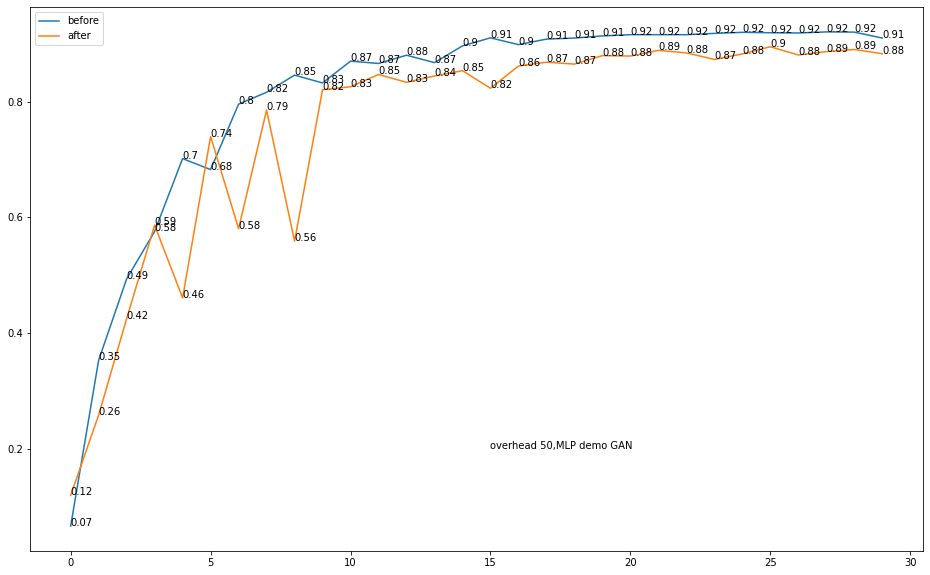

In [123]:
plt.figure(figsize=(16,10))
plt.plot(history_CNN_org.history['val_acc'],label = 'before')
[plt.annotate(round(history_CNN_org.history['val_acc'][i],2),(i,history_CNN_org.history['val_acc'][i])) for i in range(len(history_CNN_org.history['val_acc']))]
plt.plot(history_CNN_after.history['val_acc'],label = 'after')
[plt.annotate(round(history_CNN_after.history['val_acc'][i],2),(i,history_CNN_after.history['val_acc'][i])) for i in range(len(history_CNN_after.history['val_acc']))]
plt.annotate('overhead 100%,MLP demo GAN',(15,0.2))
plt.legend()
plt.show()